### Document specifications
Author: Dominik Wulf <br>
Matriculation Number: 364 100 <br>
Creation Date: 05. July 2022

### Intro

For the code various websites were used as references and get information about the implementation of the LDA models. The references used in the code below are the following: <br>

* https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html
* https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0
* https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
* https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2
* https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
* https://nicharuc.github.io/topic_modeling/

In [1]:
#import needed libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import gensim
import nltk
import re
import spacy
import en_core_web_sm
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import unicodedata
import regex as rx
import qgrid

from tqdm import tqdm
from pprint import pprint
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from nltk.stem import WordNetLemmatizer, SnowballStemmer

C:\Users\dominik\Anaconda3\lib\site-packages\qgrid\grid.py:30: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pd.__version__) > LooseVersion('0.20.0'):
C:\Users\dominik\Anaconda3\lib\site-packages\qgrid\grid.py:30: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pd.__version__) > LooseVersion('0.20.0'):
C:\Users\dominik\Anaconda3\lib\site-packages\ipywidgets\widgets\widget.py:282: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
C:\Users\dominik\Anaconda3\lib\site-packages\qgrid\grid.py:573: DeprecationWarning: metadata {'sync': True} was set from the constructor. With traitlets 4.1, metadata should be set using t

In [2]:
#import stop word list
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dominik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### ! BEFORE START SET FILEPATH AND IMPORT DATA HERE ! 

In [42]:
# import data, please insert file link to '220705_html_content_normalized.csv' file
data = pd.read_csv('C:/Users/dominik/Documents/GitHub/Masterthesis/LDA/Data/220705_html_content_normalized.csv', sep=',') 
# randomize data set
data = data.sample(frac=1, random_state = 1)

In [4]:
# view data
data

,links,html_content,word_count
723,https://ethereals.wtf/#team,HOME\nSTORY\nROADMAP\nTEAM\nNFT BASICS\nFAQ\nD...,212
1012,https://superplastic.co/collections/frontpage/...,DEFAULT TITLE\nADD TO BAG\nCase Of 12 Blindbox...,12
1683,https://eulerbeats.com/,Drops\nStake\nDocs\nContact\nFutura is here!\n...,140
1717,https://www.coolcatsnft.com/competition-rules/...,CONNECT\nCool Cats Candy Bucket Giveaway Rules...,2863
1695,https://www.divineanarchy.com/edition-3-the-bu...,ABOUT\nFAQ\nNEWS\nPLAY NOW\nEDITION 3: THE BUR...,426
...,...,...,...
715,https://nfp.daz3d.com/frequently-asked-questions,NFPets\nPartnerships\nUtility\nRoadmap\nTeam\n...,221
905,https://www.dgenesis.io/collections/prime/drips,ARBIDRIPS MINT FOR BRIDGEOOORS IS NOW LIVE - M...,673
1096,https://0xadventures.com/,Adventure Cards\nDiscord\nOpensea\nTwitter\nCo...,82
235,https://tubbycats.club/@ratwell,Profilverzeichnis\nÜber diesen Server\nMobile ...,230


In [5]:
# create corpus
documents = data['html_content']
documents = pd.DataFrame(documents)

In [6]:
# define functions to remove html content and long and short words

CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

def remove_sandl_words(s,s_count,l_count):
    return ' '.join([w for w in s.split() if len(w)>s_count and len(w)<l_count])

In [7]:
def preprocess(df):

    # remove html tags from data
    df['text_preprocessed'] = df.iloc[:, 0].str.replace(r"->","")
    df['text_preprocessed'] = df.iloc[:, 1].str.replace(r"<-","")
    df['text_preprocessed'] = df.iloc[:, 1].str.replace(r"[","<")
    df['text_preprocessed'] = df.iloc[:, 1].str.replace(r"]",">")
    df['text_preprocessed'] = df.iloc[:, 1].apply(cleanhtml)

    #remove control characters
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: rx.sub(r'\p{C}', ' ',x))
    
    #remove emails
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: rx.sub(r'\S*@\S*\s?', '',x))
    
    # remove punctuation
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: re.sub(r'[,\.!?]', '', x))

    # remove words shorter than 3
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: remove_sandl_words(x,2,20))
    
    # change to lowercase letters
    df['text_preprocessed'] = df.iloc[:, 1].map(lambda x: x.lower())
    
    return df

In [8]:
# take first preprocessing step and clean html content
documents = preprocess(documents)

In [9]:
# count words and append as column
documents["word_count"] = documents['text_preprocessed'].str.split().str.len()

In [10]:
# check dataframe if preprocessing was successful
documents.head()

,html_content,text_preprocessed,word_count
723,HOME\nSTORY\nROADMAP\nTEAM\nNFT BASICS\nFAQ\nD...,home story roadmap team nft basics faq discord...,175
1012,DEFAULT TITLE\nADD TO BAG\nCase Of 12 Blindbox...,default title add bag case blindboxes single b...,9
1683,Drops\nStake\nDocs\nContact\nFutura is here!\n...,drops stake docs contact futura here futura th...,113
1717,CONNECT\nCool Cats Candy Bucket Giveaway Rules...,connect cool cats candy bucket giveaway rules ...,2340
1695,ABOUT\nFAQ\nNEWS\nPLAY NOW\nEDITION 3: THE BUR...,about faq news play now edition the bureau hel...,348


In [11]:
# check single doc if preprocessing was successful
documents.iloc[4][1]

'about faq news play now edition the bureau hello citizens the bureau finally here part the ecosystem you have the ability interact with new in-discord ecosystem where you will tasked with the duty leveling the highest echelons society are moving along day day with incredible progress this newsletter will sharing some the most exciting announcements this week make sure take the next minutes check out the amazing updates taking place our ecosystem agenda: dev team updates: some this week’s sprint deliverables listed from last week’s newsletter will rolling over into this next sprint (sprint one the reasons why these deliverables are rolling over because spent time this past sprint onboarding for the team which was rigorous process order structure our organization based current needs among this giant onboarding process have added few new developers: cjay react architect lefty react developer backend architect skaro react developer sprint goals for sprint creating signature protocol allow

In [12]:
# remove website with more than 10.000 words 
documents = documents[documents["word_count"]<10000]

In [13]:
# count number of words in corpus
num_words = documents["word_count"].sum()
num_words

698042

In [14]:
# create bag of words for 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

In [15]:
data = documents.text_preprocessed.values.tolist()
documents_words = list(sent_to_words(data))

In [16]:
# Build the bigram models
bigram = gensim.models.Phrases(documents_words, min_count=5, threshold=100) # higher threshold fewer phrases.
# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [17]:
stop_words = stopwords.words('english')

stop_words.extend(stopwords.words('german'))

stop_words.extend(['blockchain','bitcoin','ethereum','technology','nft','nfts','mint','javascript','terms','condition','websites','terms','service'
                   ,'website','cookie','impressum','imprint','etc','cookies'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Remove Stop Words
data_words_nostops = remove_stopwords(documents_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp.max_length = 1500000

# Do lemmatization keeping only noun
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])
print(data_lemmatized[:1])

[['home', 'story', 'roadmap', 'team', 'basic', 'shop', 'contact', 'eth', 'minting', 'est', 'origin', 'wormhole', 'sheet', 'fun', 'park', 'operator', 'chaos', 'operator', 'etherealtron', 'playing', 'sharing', 'ethereal', 'artist', 'ghost', 'player', 'community', 'ethereal', 'creator', 'banana', 'oil', 'painting', 'toy', 'icon', 'work', 'collection', 'world', 'brand', 'work', 'industry', 'publication', 'lead', 'artist', 'marketing', 'strategy', 'support', 'event', 'planning', 'event', 'partnership', 'hodler', 'marketing', 'community', 'head', 'social_media', 'strategist', 'event', 'manager', 'bayc', 'hodler', 'mnmlty', 'project', 'management', 'product', 'development', 'lead', 'developer', 'laser', 'falcon', 'brand', 'development', 'strategy', 'community', 'manager', 'engagement', 'strategy', 'bayc', 'hodler', 'ethereal', 'condition']]


In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 3), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 3), (17, 1), (18, 3), (19, 1), (20, 1), (21, 1), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 2), (31, 2), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 3), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1)]]


In [20]:
# count words after preprocessing
words_total = 0
for t in texts:
    x = len(t)
    words_total = words_total + x
words_total

200557

In [21]:
#initilize first LDA Model
from multiprocessing import Process, freeze_support
if __name__ == "__main__":
    freeze_support()
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=7, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    # Print the Keyword in the 8 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]

[(0,
  '0.018*"collection" + 0.016*"world" + 0.016*"community" + 0.016*"art" + '
  '0.013*"project" + 0.009*"piece" + 0.009*"time" + 0.008*"metaverse" + '
  '0.007*"detail" + 0.007*"dgenesis"'),
 (1,
  '0.028*"use" + 0.026*"information" + 0.020*"site" + 0.019*"right" + '
  '0.018*"content" + 0.016*"service" + 0.016*"datum" + 0.014*"user" + '
  '0.012*"access" + 0.012*"agreement"'),
 (2,
  '0.027*"game" + 0.018*"team" + 0.016*"community" + 0.013*"cat" + '
  '0.012*"mission" + 0.012*"time" + 0.010*"woman" + 0.009*"experience" + '
  '0.008*"web" + 0.008*"planet"'),
 (3,
  '0.052*"infinite_irl" + 0.034*"price" + 0.013*"hornet" + 0.010*"cart" + '
  '0.009*"admit_one" + 0.009*"web" + 0.008*"extension" + 0.007*"mooner" + '
  '0.006*"cat_detail" + 0.006*"listing"'),
 (4,
  '0.025*"wallet" + 0.023*"collection" + 0.015*"contract" + 0.014*"art" + '
  '0.013*"team" + 0.013*"opensea" + 0.013*"access" + 0.012*"claim" + '
  '0.011*"holder" + 0.011*"community"'),
 (5,
  '0.029*"card" + 0.024*"veefrien

In [22]:
#calculate coherence score of above model
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, 
                                                  dictionary=id2word, 
                                                      coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.49053492986160313


In [23]:
# function to calculate coherence score for multiple models and save them to a list
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):

    coherence_values = []
    model_list = []

    for n_topics in tqdm(range(start, limit+1, step)):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics= n_topics, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
# define number of topics to 
total_num_topics = 20
# compute coherence for 20 topics and save them to values
models, cvalues = compute_coherence_values(id2word,corpus,texts,total_num_topics)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [11:20<00:00, 35.81s/it]


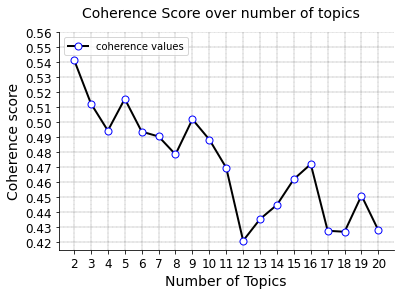

In [25]:
# Show graph over number of topics
limit=total_num_topics; start=2; step=1;
x = range(start, limit+1, step)
y = cvalues

# predefine the graph results 
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [12.00, 6.00]
#plt.rcParams["figure.autolayout"] = True
ticksize = 12
labelsize = 14
markersize = 7
markercolor = 'blue'

#plot the graph
plt.plot(x, y, color='black', linestyle='-', linewidth = 2,
         marker='o', markerfacecolor='white', markeredgecolor=markercolor, markersize=markersize, label ="coherence values")

# define range on axes
plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize = ticksize)
plt.yticks(np.arange(round(min(y),2), max(y)+0.02, 0.01), fontsize = ticksize)

# name axes
plt.xlabel("Number of Topics", fontsize = labelsize)
plt.ylabel("Coherence score", fontsize = labelsize)

# title & legend
plt.suptitle("Coherence Score over number of topics", fontsize = 14, y = 0.97)
plt.legend(loc='upper left')

#remove borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

#grid
plt.grid(color = 'black',which = 'both', linestyle = '--', linewidth = 0.25)

# print plot
plt.show()

In [27]:
def compute_coherence_values_a(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [28]:
grid = {}
grid['Validation_Set'] = {}

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.11))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.11))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)

model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm(total=len(alpha)*len(beta))
    
    # iterate through validation corpuses
    for a in alpha:
        # iterare through beta values
        for b in beta:
            # get the coherence score for the given parameters
            cv = compute_coherence_values_a(corpus=corpus, dictionary=id2word, 
                                          k=9, a=a, b=b)
            # Save the model results
            model_results['Topics'].append(9)
            model_results['Alpha'].append(a)
            model_results['Beta'].append(b)
            model_results['Coherence'].append(cv)

            pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [47:07<00:00, 25.70s/it]


In [29]:
model_res = pd.DataFrame(model_results)
model_res.sort_values(by = ['Coherence'],ascending = False)

,Topics,Alpha,Beta,Coherence
49,9,0.45,symmetric,0.530907
21,9,0.23,0.12,0.524371
29,9,0.23,symmetric,0.522632
50,9,0.56,0.01,0.522363
13,9,0.12,0.34,0.520662
...,...,...,...,...
70,9,0.78,0.01,0.446906
47,9,0.45,0.78,0.443578
38,9,0.34,0.89,0.442701
37,9,0.34,0.78,0.439395


In [30]:
best_alpha = 0.45
best_beta = 'symmetric'
best_num_top = 9

final_LDA_nouns = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=best_num_top, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=best_alpha,
                                           eta=best_beta)

coherence_LDA_nouns = compute_coherence_values_a(corpus=corpus, dictionary=id2word, 
                                          k=best_num_top, a=best_alpha, b=best_beta)

In [32]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

topic_data2 = pyLDAvis.gensim_models.prepare(final_LDA_nouns, corpus, id2word) 
topic_data2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.136356 -0.121125       1        1  19.189449
1      0.202110 -0.061685       2        1  18.437047
8      0.264920  0.009341       3        1  13.802316
4     -0.070975 -0.157855       4        1  13.263399
2     -0.167291 -0.139460       5        1  10.341652
7      0.259658  0.000251       6        1   9.374204
6     -0.153258  0.042312       7        1   8.186965
5     -0.134899  0.102427       8        1   5.099040
3     -0.063909  0.325794       9        1   2.305926, topic_info=             Term         Freq        Total Category  logprob  loglift
217   information  1888.000000  1888.000000  Default  30.0000  30.0000
384          game  1624.000000  1624.000000  Default  29.0000  29.0000
464        wallet  1536.000000  1536.000000  Default  28.0000  28.0000
351           use  2192.000000  2192.000000  Default  27.0000  27.0000
64            art  1584.000000  1584.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1220          set   326.131654   355.974433   Topic9  -2.6519   3.6821
516         price   298.570697   595.224358   Topic9  -2.7402   3.0798
1743          hat    28.170329    39.532405   Topic9  -5.1009   3.4308
561         floor    33.317354    63.712386   Topic9  -4.9331   3.1214
888        volume    26.375680    47.489935   Topic9  -5.1667   3.1816

[539 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
63        1  0.012284  access
63        2  0.237703  access
63        3  0.353176  access
63        4  0.336592  access
63        5  0.012284  access
...     ...       ...     ...
614       1  0.501160    year
614       2  0.042813    year
614       4  0.249321    year
614       5  0.203990    year
3852      7  0.972302     zoo

[923 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 9, 5, 3, 8, 7, 6, 4])

In [33]:
#save inter topic distance map
pyLDAvis.save_html(topic_data2, '220711_pyLDA_NFT_LDA_nouns.html')

In [34]:
all_topics = {} # Create empty dictionary
num_terms = 20 # Adjust number of words to represent each topic
lambd = 0.5 # Set the lambda parameter after viewing Intertopic Distance Map
for i in range(1,best_num_top+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data2.topic_info[topic_data2.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

In [35]:
# show topic dataframe 
topic_words = pd.DataFrame(all_topics).T
topic_words

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Topic 1,art,dgenesis,artist,piece,world,print,collection,fren,life,project,detail,lore,wizard,story,trait,shape,history,arbitrum,movement,music
Topic 2,information,datum,service,account,security,user,email,privacy_policy,request,privacy,somnium_space,address,purpose,provider,consent,policy,device,somnium,site,use
Topic 3,agreement,site,app,arbitration,party,claim,dispute,transaction,purchase,provision,risk,loss,damage,liability,access,law,vfnft,purchaser,court,payment
Topic 4,rtfkt,holder,opensea,collection,roadmap,metaverse,contract,phase,buy,discord,merch,ape,utility,access,team,member,crew,skullz,club,join
Topic 5,community,team,cat,web,woman,brand,experience,cryptokittie,lab,week,partnership,season,kitty,development,gift,news,manager,swamp,driver,developer
Topic 6,license,right,content,use,owner,ownership,art,display,condition,network,platform,smart_contract,user,collectible,grant,galacticape,application,limitation,actual_owner,hornet
Topic 7,game,player,egg,farmer,voxie,play,eulerbeat,land,cryptozoo,revv,battle,carrot,block,farm,creature,world,parcel,hunter,pack,mechanic
Topic 8,veefriend,card,wallet,punk,veecon,guardian,gold,icon,telegram,connect,hoot,duck,chibi,dino,cart,character,chibi_lab,box,twig,background
Topic 9,infinite_irl,set,blocknumber_number,price,min_read,admit_one,number_set,miner,house_legend,listing,shitpunk,bmc,genes_egg,photo,try_knowable,tile,egg_duck,love_podcast,tl_dr,cryptohoot


In [40]:
# tabelize data to display in thesis
table_data = {
    "Model":["LDA_nouns"],
    "Words initial":[num_words],
    "Words after preprocess":[words_total],
    "Number of Topics":[best_num_top],
    "LDA Alpha":[best_alpha],
    "LDA Beta":[best_beta],
    "LDA coherrence":[coherence_LDA_nouns],
    "LDA Lambda":[lambd]
    }

table_inf = pd.DataFrame(table_data)

In [41]:
# display info table
table_inf

,Model,Words initial,Words after preprocess,Number of Topics,LDA Alpha,LDA Beta,LDA coherrence,LDA Lambda
0,LDA_nouns,698042,200557,9,0.45,symmetric,0.530907,0.5
